In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.integrate import odeint

%matplotlib inline

In [5]:
# Set Global constants
G = 6.674e-8                    # Gravitational constant - cgs units
c = 3.0e10                      # Speed of light - cm/s
R = 1.0e6                       # Magnetar radius - km
Msol = 1.99e33                  # Solar mass - grams
M = 1.4 * Msol                  # Magnetar mass - grams
I = (4.0 / 5.0) * M * R ** 2.0  # Moment of Inertia
GM = G * M

# Time array to calculate over
t_arr = np.logspace(0.0, 6.0, num=10001, base=10.0)

In [6]:
# Calculate initial values to pass to ODEINT
def init_conds(arr):
    """
Function to calculate the initial conditions to pass to ODEINT by converting units.
Principally, converting initial disc mass from solar masses to grams, and calculating an initial angular frequency from a spin period in milliseconds.

Usage >>> init_conds(arr)
arr : list --> element 1: Initial spin period in milliseconds
               element 2: Initial disc mass in solar masses

Returns a list object --> element 1: Initial disc mass in grams
                          element 2: Initial angular frequency in "per second"
    """
    Mdisc0 = arr[1] * Msol                      # Disc mass
    omega0 = (2.0 * np.pi) / (1.0e-3 * arr[0])  # Angular frequency

    return [Mdisc0, omega0]

In [7]:
# Model to be passed to ODEINT to calculate evolving disc mass and angular frequency
def ODEs(y, t, B, MdiscI, RdiscI, epsilon, delta, n, alpha=0.1, cs7=1.0, k=0.9):
    """
Function to pass to ODEINT which will calculate a disc mass and angular frequency for given time points.

Usage >>> ODEs(y, t, B, MdiscI, RdiscI, epsilon, delta, n)
      y : output of init_conds()
      t : array of time points (t_arr above)
      B : Magnetic Field Strength - 10^15 Gauss (float)
 MdiscI : Initial disc mass - Solar masses (float)
 RdiscI : Disc radius - km (float)
epsilon : timescale ration (float)
  delta : mass ratio (float)
      n : propeller "switch-on" (float)
  alpha : Viscosity prescription (float)
    cs7 : Sound speed - 10^7 cm/s (float)
      k : capping fraction (float)
    """
    # Initial conditions
    Mdisc, omega = y
    
    # Constants
    Rdisc = RdiscI * 1.0e5                 # Disc radius - cm
    tvisc = Rdisc / (alpha * cs7 * 1.0e7)  # Viscous timescale - s
    mu = 1.0e15 * B * R ** 3.0             # Magnetic Dipole Moment
    M0 = delta * MdiscI * Msol             # Global Fallback Mass Budget - g
    tfb = epsilon * tvisc                  # Fallback timescale - s
    
    # Radii - Alfven, Corotation, Light Cylinder
    Rm = mu ** (4.0 / 7.0) * GM ** (-1.0 / 7.0) * (Mdisc / tvisc) ** (-2.0 / 7.0)
    Rc = (GM / omega ** 2.0) ** (2.0 / 3.0)
    Rlc = c / omega
    # Cap the Alfven radius
    if Rm >= k * Rlc:
        Rm = k * Rlc
    
    w = (Rm / Rc) ** (3.0 / 2.0)  # Fastness parameter
    
    bigT = 0.5 * I * omega ** 2.0  # Rotational energy
    modW = (0.6 * M * c ** 2.0 * ((GM / (R * c ** 2.0)) / (1.0 - 0.5 * (GM / (R * c ** 2.0)))))  # Binding energy
    rot_param = bigT / modW  # Rotation parameter
    
    Ndip = (-1.0 * mu ** 2.0 * omega ** 3.0) / (6.0 * c ** 3.0)  # Dipole torque
    
    # Mass flow rates and efficiencies
    eta2 = 0.5 * (1.0 + np.tanh(n * (w- 1.0)))
    eta1 = 1.0 - eta2
    Mdotprop = eta2 * (Mdisc / tvisc)  # Propelled
    Mdotacc = eta1 * (Mdisc / tvisc)   # Accreted
    Mdotfb = (M0 / tfb) * ((t + tfb) / tfb) ** (-5.0 / 3.0)  # Fallback rate
    Mdotdisc = Mdotfb - Mdotprop - Mdotacc  # Mass flow through the disc
    
    if rot_param > 0.27:
        Nacc = 0.0  # Prevents magnetar break-u[
    else:
        # Accretion torque
        if Rm >= R:
            Nacc = (GM * Rm) ** 0.5 * (Mdotacc - Mdotprop)
        else:
            Nacc = (GM * R) ** 0.5 * (Mdotacc - Mdotprop)
    
    omegadot = (Nacc + Ndip) / I  # Angular frequency time derivative
    
    return Mdotdisc, omegadot

Text(0,0.5,'Propeller Efficiency, $\\eta_2$')

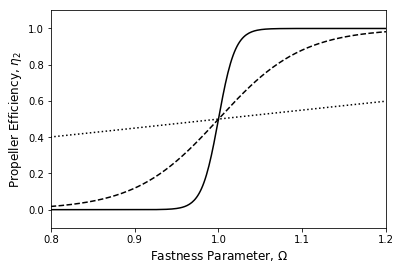

In [8]:
lines = [':', '--', '-']

# Constants
B = 1.0  # Magnetic field strength - 10^15 Gauss
P = 1.0  # Initial spin period - milliseconds
MdiscI = 0.1  # Initial disc mass - Solar masses
RdiscI = 100.0  # Disc radius - km
epsilon = 1.0
delta = 1.0e-6
alpha = 1.0
cs7 = 1.0

# Set-up
mu = 1.0e15 * B * R ** 3.0
Rdisc = RdiscI * 1.0e5
tvisc = Rdisc / (alpha * cs7 * 1.0e7)

n_vals = [1.0, 10.0, 50.0]
y0 = init_conds([P, MdiscI])

# Loop over values of n
for i, n in enumerate(n_vals):
    soln = odeint(ODEs, y0, t_arr, args=(B, MdiscI, RdiscI, epsilon, delta, n))

    # Split soln
    Mdisc = soln[:,0]
    omega = soln[:,1]
    
    # Radii
    Rm = mu ** (4.0 / 7.0) * GM ** (-1.0 / 7.0) * (Mdisc / tvisc) ** (-2.0 / 7.0)
    Rc = (GM / omega ** 2.0) ** (1.0 / 3.0)
    Rlc = c / omega
    Rm = np.where(Rm >= 0.9 * Rlc, 0.9 * Rlc, Rm)
    
    w = np.sort((Rm / Rc) ** (3.0 / 2.0))  # Sorted to make plotting nicer
    eta2 = 0.5 * (1.0 + np.tanh(n * (w - 1.0)))
    
    # Plotting
    plt.plot(w, eta2, c='k', ls=lines[i], label='n = {}'.format(int(n)))

# Plot formatting
plt.xlim(0.8, 1.2)
plt.ylim(-0.1, 1.1)
plt.xticks([0.8, 0.9, 1.0, 1.1, 1.2])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Fastness Parameter, $\Omega$', fontsize=12)
plt.ylabel(r'Propeller Efficiency, $\eta_2$', fontsize=12)